# 0. Initialize

## 0.1. Import Libraries

In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys, glob
import gzip
import random
import tqdm
import json
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)

from IPython import display
import matplotlib as mpl
from matplotlib import pyplot as plt

## 0.2. DEFINE VARIABLES 

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [126]:
DATA_PATH = '/content/drive/MyDrive/CS412/Project/'

ROUND = 2 # This project will have 3 rounds of predictions: 1,2,3
STUDENT_ID = '26458'
PROJECT_CODES = ['CS412253858dea9d4-Emir', "CS41214c7cd9e97e7-Doğkan", "CS412869ce1d0d64b-Melih", "CS412518fc93fe64c-Kerem", "CS4123cc79a6292a7-Alper"] # Same code for the annotation eg. CS412xxxxx

## 0.3. Read Training & Evaluation Data

### 0.3.1. Get the labels for tweets

In [6]:
trainingTweetDf = pd.read_csv('{}training-tweet.csv'.format(DATA_PATH), dtype={'tweet_id': str, 'isPolitical': str})
#trainingTweetDf = pd.read_csv('training-tweet.csv', dtype={'tweet_id': str, 'isPolitical': str})
trainingTweetDf

,tweet_id,isPolitical
0,1418828259614236672,No
1,1424439289753083911,No
2,1354305766644199427,Yes
3,1438890637282193408,Yes
4,1397543048452591616,No
...,...,...
2995,1416144676990722053,Yes
2996,1466793383788220421,Yes
2997,1448350353439744003,Yes
2998,1423327989044072453,Yes


In [7]:
trainingTweetDf.isPolitical.value_counts()

No     1509
Yes    1491
Name: isPolitical, dtype: int64

In [8]:
trainingTweetDf = pd.read_csv('{}training-tweet.csv'.format(DATA_PATH), dtype={'tweet_id': str, 'isPolitical': str})
for code in PROJECT_CODES:
  print(code)
  annotatedTweetDf = pd.read_csv('{}annotated_tweets_{}.csv'.format(DATA_PATH, code), dtype={'tweet_id': str, 'isPolitical': str})
  annotatedTweetDf.dropna(inplace=True)
  columns = annotatedTweetDf.columns.tolist()
  columns[0] = "tweet_id"
  annotatedTweetDf.columns = columns
  annotatedTweetDf["tweet_id"]= annotatedTweetDf["tweet_id"].astype(str)
  trainingTweetDf = pd.concat([trainingTweetDf, annotatedTweetDf])
  trainingTweetDf = trainingTweetDf[['tweet_id', 'isPolitical']]
trainingTweetDf

CS412253858dea9d4-Emir
CS41214c7cd9e97e7-Doğkan
CS412869ce1d0d64b-Melih
CS412518fc93fe64c-Kerem
CS4123cc79a6292a7-Alper


,tweet_id,isPolitical
0,1418828259614236672,No
1,1424439289753083911,No
2,1354305766644199427,Yes
3,1438890637282193408,Yes
4,1397543048452591616,No
...,...,...
245,1456676908142407683,No
246,1441887862262321152,No
247,1451484210464690192,No
248,1351221497327706114,No


In [9]:
trainingTweetDf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4242 entries, 0 to 249
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   tweet_id     4242 non-null   object
 1   isPolitical  4242 non-null   object
dtypes: object(2)
memory usage: 99.4+ KB


In [10]:
trainingTweetDf.isPolitical.value_counts()

No     2240
Yes    2002
Name: isPolitical, dtype: int64

### 0.3.2. Get the labels for users

In [11]:
trainingUserDf = pd.read_csv('{}training-user.csv'.format(DATA_PATH))
#trainingUserDf = pd.read_csv('training-user.csv')
trainingUserDf

,screen_name,isBot
0,faracyaziyor,No
1,elifgibirt,No
2,buocguldurdu,No
3,__baba1yaga_,No
4,hakanyilmazcebi,No
...,...,...
2995,kupakralicesi53,No
2996,muhamme44063672,No
2997,galaopta,Not sure
2998,hygea0,No


In [12]:
trainingUserDf.isBot.value_counts()

No          2363
Yes          401
Not sure     236
Name: isBot, dtype: int64

In [13]:
trainingUserDf = pd.read_csv('{}training-user.csv'.format(DATA_PATH))
for code in PROJECT_CODES:
  print(code)
  annotatedUserDf = pd.read_csv('{}annotated_users_{}.csv'.format(DATA_PATH, code))
  annotatedUserDf.dropna(inplace=True)
  columns = annotatedUserDf.columns.tolist()
  columns[0] = "screen_name"
  annotatedUserDf.columns = columns
  annotatedUserDf["screen_name"]= annotatedUserDf["screen_name"].astype(str)
  trainingUserDf = pd.concat([trainingUserDf, annotatedUserDf])
  trainingUserDf = trainingUserDf[['screen_name', 'isBot']]
trainingUserDf

CS412253858dea9d4-Emir
CS41214c7cd9e97e7-Doğkan
CS412869ce1d0d64b-Melih
CS412518fc93fe64c-Kerem
CS4123cc79a6292a7-Alper


,screen_name,isBot
0,faracyaziyor,No
1,elifgibirt,No
2,buocguldurdu,No
3,__baba1yaga_,No
4,hakanyilmazcebi,No
...,...,...
245,2felsefeci,No
246,gurcusel,Yes
247,iyangchicken,No
248,efruze__6161,Yes


### 0.3.3. Expand your dataset with metadata and tweets

In [15]:
# You can also expand training data by downloading your own labeled datasets following the link
# Download the documents under "Link to training data"

#print('http://www.onurvarol.com/AnnotationTwitterTR/reports/report_{}.html'.format(PROJECT_CODE))

## 1. Landing Page

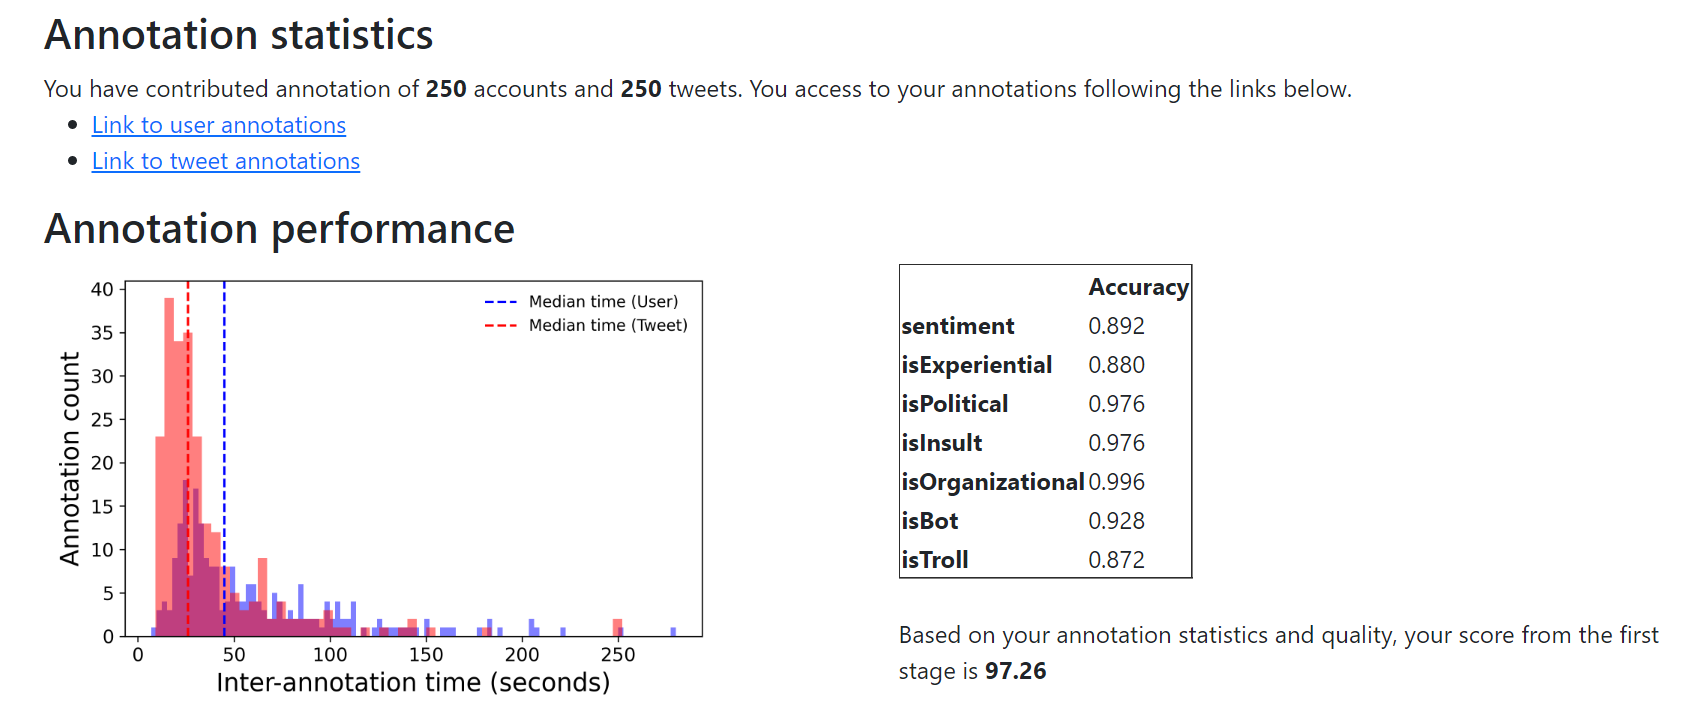

In [ ]:
display.Image("https://i.imgur.com/IHvQHIf.png")

## 2. Link for Downloading Training Data

At the bottom of the page, you will see the **LINK FOR FILES**

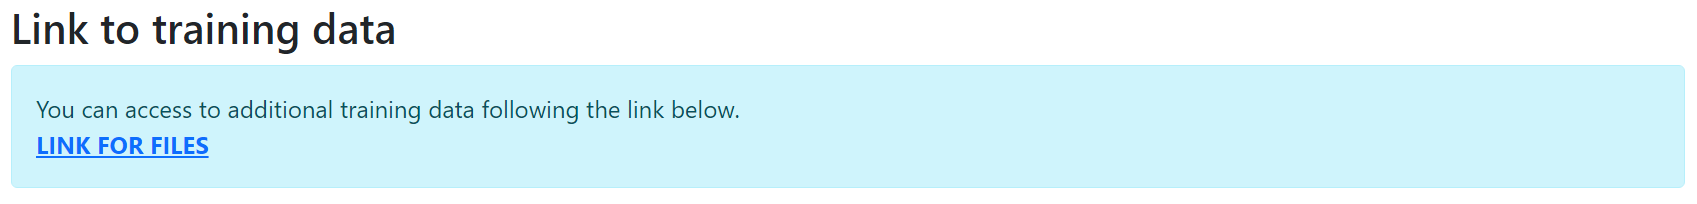

In [ ]:
display.Image("https://i.imgur.com/t19vAjr.png")

## 3. Google Drive

You can download the following project files from Google Drive

- **user_profiles.jsons.gz**: Contains user metadata for bot detection phase of your project
- **user_tweets.jsons.gz**: Contains at most 200 tweets of the above mentioned users'
- **tweet_metadata.jsons.gz**: Contains tweets and their metadata for the political tweet detection of your project

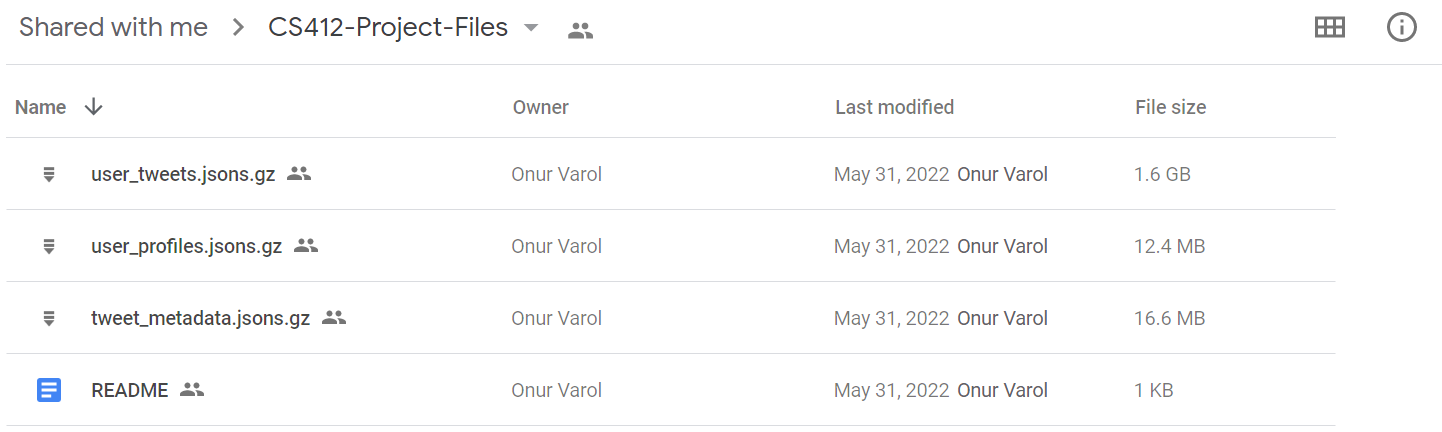

In [ ]:
display.Image("https://i.imgur.com/7FjWPLi.png")

# 1. EXTRACT FEATURES
Under *1.1. Political Tweet Detection* and *1.2. Bot Detection*, we firstly collect raw data for processing. We then combine some of them (total_interactions = num_favorites + num_retweets) or use them to extract features (whether the tweet has one of the political entities @meralaksener, @kilicdarogluk etc.).

We expect you to collect more raw data from **tweet_metadata**, **user_profiles** and **user_tweets** files by creating a function as shown in below examples such as *check_if_retweet()* and using it while iterating over data as shown under *Merge Collected Features*.

We also expect you to create new variables as much as you can from the data in order to make your predictions more accurate. For example, you may want to check:

- The tweet sources that a user frequently uses
- Whether the user is a verified account or not

...

to assess whether **a user is a bot or not** and whether **a tweet is political or not**.

In [16]:
#PATH_TO_DOWNLOADED = 'C:/Users/Tunah/OneDrive/Masaüstü/okul/CS 412/Annotation/deneme1/twitterproject/'
#PATH_TO_DOWNLOADED = 'D:/Users/suuser/Desktop/Sabancı/CS412/spring-2022/project/'
PATH_TO_DOWNLOADED = DATA_PATH

## 1.1. Political Tweet Detection
This part stands for the feature extraction of tweets. We start with collecting the raw data from *tweet_metadata*, then use some of them to extract features.

### 1.1.1. Get Raw Data

#### 1.1.1.1. Check if Retweet

In [17]:
def check_if_retweet(tweet_metadata_line):
    is_retweet = 0
    retweeted_username = None

    try:
        tweet_metadata_line['retweeted_status']
        retweeted_username = tweet_metadata_line['retweeted_status']['user']['screen_name'].lower()
        is_retweet = 1

    except KeyError:
        pass

    return is_retweet, retweeted_username

#### 1.1.1.2. Get Tweet Text

In [18]:
def get_tweet_text(tweet_metadata_line):
    text = tweet_metadata_line['text']
    
    return text

#### 1.1.1.3. Get Tweet ID

In [19]:
def get_tweet_id(tweet_metadata_line):
    id_str = tweet_metadata_line['id_str']
    
    return id_str

#### 1.1.1.4. Get Number of Mentions and Hashtags

In [20]:
def get_number_mentions_hashtags(tweet_metadata_line):
    num_mentions = len(tweet_metadata_line['entities']['user_mentions'])
    num_hashtags = len(tweet_metadata_line['entities']['hashtags'])

    return num_mentions, num_hashtags

#### 1.1.1.5. Get Number of Retweets and Favorites

In [21]:
def get_number_retweets_favorites(tweet_metadata_line):
    retweet_count = tweet_metadata_line['retweet_count']
    favorite_count = tweet_metadata_line['favorite_count']
    
    return retweet_count, favorite_count

#### 1.1.1.6. Get User Info

In [22]:
def get_user_info(tweet_metadata_line):
    id = tweet_metadata_line['user']['id_str']
    screen_name = tweet_metadata_line['user']['screen_name'].lower()
    description = tweet_metadata_line['user']['description']

    return id, screen_name, description

### 1.1.2. Derive Manually Crafted Features

#### 1.1.2.1. Check for political entity in text

In [23]:
def check_political_ent(text):
    
    # the list below can be modified and some new names may be added (or removed)
    list_of_entities = ['meral_aksener', 'kilicdarogluk', 'vekilince', 'RTErdogan', 'MevlutCavusoglu', 'umitozdag']
    list_of_entities = ['meral_aksener', 'kilicdarogluk', 'vekilince', 'RTErdogan', 'MevlutCavusoglu', 'umitozdag','drfahrettinkoca','ziyaselcuk','suleymansoylu','Canan_Kaftanci','ekrem_imamoglu','mansuryavas06','tcmeb','Akparti','Chp','kasapoglu']
    
    # eğitim bakanı fahrettin koca falan eklenmeli
    entities_in_text = [ent for ent in list_of_entities if ent.lower() in text.lower()]
    number_entities = len(entities_in_text)

    return number_entities

#### 1.1.2.2. Number of total interactions

In [24]:
def total_interactions(retweet_count, favorite_count):
    total_num_interactions = retweet_count + favorite_count
    
    return total_num_interactions

### 1.1.2. Collect data using the functions above and transform into a Pandas DataFrame

In [25]:
dfPolitical = {'tweet_id':[],
              'is_retweet':[],
              'retweeted_username':[],
              'text':[],
              'num_mentions':[],
              'num_hashtags':[],
              'num_retweets':[],
              'num_favorites':[],
              'user_id':[],
              'user_screen_name':[],
              'user_description':[],
              'num_political_entities':[],
              'total_interactions':[]}


with gzip.open(f"{PATH_TO_DOWNLOADED}tweet_metadata.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)
        
        # raw data:
        id_str = get_tweet_id(line)
        is_retweet, retweeted_username = check_if_retweet(line)
        text = get_tweet_text(line)
        num_mentions, num_hashtags = get_number_mentions_hashtags(line)
        retweet_count, favorite_count = get_number_retweets_favorites(line)
        user_id_str, screen_name, user_description = get_user_info(line)

        # manually crafted data:
        num_political_entities = check_political_ent(text)
        total_num_interactions = total_interactions(retweet_count, favorite_count)

        dfPolitical['tweet_id'].append(id_str)
        dfPolitical['is_retweet'].append(is_retweet)
        dfPolitical['retweeted_username'].append(retweeted_username)
        dfPolitical['text'].append(text)
        dfPolitical['num_mentions'].append(num_mentions)
        dfPolitical['num_hashtags'].append(num_hashtags)
        dfPolitical['num_retweets'].append(retweet_count)
        dfPolitical['num_favorites'].append(favorite_count)
        dfPolitical['user_id'].append(user_id_str)
        dfPolitical['user_screen_name'].append(screen_name)
        dfPolitical['user_description'].append(user_description)
        dfPolitical['num_political_entities'].append(num_political_entities)
        dfPolitical['total_interactions'].append(total_num_interactions)

In [26]:
dfPolitical = pd.DataFrame(dfPolitical)
dfPolitical

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,num_political_entities,total_interactions
0,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,0
1,1445677417150889986,1,ekrem_imamoglu,RT @ekrem_imamoglu: Geldikleri gibi gittiler… ...,1,0,6706,0,1263130166961864705,hasanak11633015,64 Jahre alt,1,6706
2,1456638729620230149,1,yenisafak,RT @yenisafak: İYİ PARTİLİ TÜRKKAN ŞEHİT AĞABE...,1,0,1545,0,2958652582,buyukdogu58,Katılıyorum: RT+FAV,0,1545
3,1451295314074341381,1,ekrem_imamoglu,RT @ekrem_imamoglu: Bu gece ben: ❤️💛\nTebrikle...,1,0,7470,0,1447285927471112194,gskaya444,,1,7470
4,1440610747134844929,1,umitozdag,RT @umitozdag: Sayın Bakan demek yüzmeyi öğren...,1,0,745,0,379944275,cerenncan,,1,745
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32997,1439639972177489926,1,deryayanikashb,RT @deryayanikashb: AK Parti Çanakkale İl Başk...,1,0,48,0,165689533,sezayicimen,İst.Aydın Üniversitesi Mahalli İdareler ve Yer...,0,48
32998,1467519965473423362,1,kilicdarogluk,RT @kilicdarogluk: Türkiye Barolar Birliği 36....,1,0,4438,0,408719429,sdiplen1,Hepimiz birileri için kurallarımızı çiğnedik,1,4438
32999,1423666826282668035,1,rterdogan,RT @RTErdogan: Geleceğe Nefes kampanyasıyla he...,1,0,14311,0,1004379711890485248,soguzsoylu,AK Parti Yumurtalık İlçe Başkanı,1,14311
33000,1417025303894007810,1,thetubaca,RT @thetubaca: Hasta tutuklu Ekim Polat açlık ...,3,0,16,0,1049663929348222985,mhmt_ckmk04,667 ile yılları çalınan gurebadan bir garip...,0,16


## 1.2. From Users

### 1.2.1. Get user metadata from user_profiles.jsons.gz

#### 1.2.1.1. Get user info metadata

In [ ]:
def get_user_info_metadata(user_metadata_line):
    
    user_id = user_metadata_line['id_str']
    user_name = user_metadata_line['name']
    user_screen_name = user_metadata_line['screen_name'].lower()
    user_location = user_metadata_line['location']
    user_description = user_metadata_line['description']
    user_followers_count = user_metadata_line['followers_count']
    user_friends_count = user_metadata_line['friends_count']
    
    dictionary = {'user_id':user_id, 'user_name': user_name, 'user_screen_name':user_screen_name, 'user_location':user_location,
     'user_description':user_description, 'user_followers_count':user_followers_count, 'user_friends_count':user_friends_count}

    return dictionary

#### 1.2.1.2. Get followers/(followers+friends) ratio

In [ ]:
def get_followers_all_ratio(user_followers_count, user_friends_count):
    
    if user_friends_count + user_followers_count == 0:
        followers_all_ratio = 0

    else:
        followers_all_ratio =  user_followers_count / (user_friends_count + user_followers_count)

    return followers_all_ratio

#### 1.2.1.3. Get description length

In [ ]:
def get_desc_len(user_description):
    
    description_len = len(user_description)

    return description_len

In [ ]:
dfBot = {'user_id':[],
         'user_name':[],
         'user_screen_name':[],
         'user_location':[],
         'user_description':[],
         'user_followers_count':[],
         'user_friends_count':[],
         'description_len':[],
         'followers_to_all_ratio':[]}

with gzip.open(f"{PATH_TO_DOWNLOADED}user_profiles.jsons.gz", "rb") as f:
    for line in f:
        line = json.loads(line)

        dictionary = get_user_info_metadata(line)
        for k,v in dictionary.items():
            dfBot[k].append(v)

        
        # manually crafted data:
        description_len = get_desc_len(dictionary['user_description'])
        dfBot['description_len'].append(description_len)
        
        followers_all_ratio = get_followers_all_ratio(dictionary['user_followers_count'], 
                                                      dictionary['user_friends_count'])

        dfBot['followers_to_all_ratio'].append(followers_all_ratio)

In [ ]:
dfBot = pd.DataFrame(dfBot)
dfBot

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017
1,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594
4,1349294559797370881,Muti_79,muti_79,"Ankara, Türkiye",,3866,3937,0,0.495450
...,...,...,...,...,...,...,...,...,...
31816,467645507,T.C. İçişleri Bakanlığı,tc_icisleri,Türkiye,"T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...",2408670,29,119,0.999988
31817,1246020601996816385,tuncay,tuncayyilmz,"Gebze, Türkiye",her şeyimi buldum,8191,8183,17,0.500244
31818,601097854,GMG Kastamonuspor Kulübü,gmgkastamonusk,Kastamonu,GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...,9323,20,82,0.997859
31819,356064164,Show TV,showtv,"İstanbul, Türkiye",Show TV Resmi Twitter Profili https://t.co/d0g...,1355456,111,101,0.999918


### 1.2.2. Get Tweet Info of Users in user_profiles.jsons.gz

#### 1.2.2.1. Check ratio of retweets to all tweets

In [ ]:
def get_retweet_tweet_ratio(line):
    number_retweets = 0
    number_original_tweets = 0

    for tweet in line['tweets']:
        try:
            tweet['retweeted_status']
            number_retweets += 1
                
        except:
            number_original_tweets += 1
            
    total_tweets = number_retweets + number_original_tweets
    
    if total_tweets == 0:
        retweet_total_ratio = None
    else:
        retweet_total_ratio = number_retweets/(total_tweets)
    
    return retweet_total_ratio

#### 1.2.2.2. Check median number of favorites

In [ ]:
def get_median_number_favorites(line):
    num_median_favorites = np.median([tweet['favorite_count'] for tweet in line['tweets']])

    return num_median_favorites

### 1.2.3. Collect data using the functions above and transform into a Pandas DataFrame

In [ ]:
''' HOCANIN KODU
dfBotTweets = {'user_id':[],
               'retweet_total_ratio':[],
               'num_median_favorites':[],
               'num_of_tweets':[]}
'''

dfBotTweets = {'user_id':[],
               'retweet_total_ratio':[],
               'num_median_favorites':[]
               }

i = 0

with gzip.open(f"{PATH_TO_DOWNLOADED}user_tweets.jsons.gz", "rb") as f:
    for line in f:

        line = json.loads(line)

        user_id = line['user_id']
        dfBotTweets['user_id'].append(user_id)
        
        retweet_total_ratio = get_retweet_tweet_ratio(line)
        dfBotTweets['retweet_total_ratio'].append(retweet_total_ratio)
        
        num_median_favorites = get_median_number_favorites(line)
        dfBotTweets['num_median_favorites'].append(num_median_favorites)

        i += 1
        
        if i % 10000 == 0:
            print(i)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


10000
20000


In [ ]:
print(len(dfBotTweets['user_id']))
print(len(dfBotTweets['retweet_total_ratio']))
print(len(dfBotTweets['num_median_favorites']))

29906
29906
29906


In [ ]:
dfBotTweets = pd.DataFrame(dfBotTweets)
dfBotTweets

,user_id,retweet_total_ratio,num_median_favorites
0,1044821071,0.090000,57.0
1,1086355147,0.172973,10.0
2,205625453,0.000000,9.0
3,1382717948092157953,0.356784,0.0
4,1302055645307375618,0.646154,0.0
...,...,...,...
29901,1865050056,0.890411,0.0
29902,1336329028324577281,0.783920,0.0
29903,1214219054329675777,0.970588,0.0
29904,310390437,0.875000,0.0


### 1.2.3. Merge dfBot and dfBotTweets

In [ ]:
dfBotAll = dfBot.merge(dfBotTweets,
                       how='left')

dfBotAll[['retweet_total_ratio', 'num_median_favorites']] = dfBotAll[['retweet_total_ratio', 'num_median_favorites']].fillna(0)

dfBotAll

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,retweet_total_ratio,num_median_favorites
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0.060,1.0
1,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0.200,107.0
2,2490178497,"Nejla ÖNÇIRAK😷 bilgin yoksa , fikrin de olmasın👍",oykunejla,izmir,Önce insan...\nAnne❤\nHemşire❤\nHayvansever❤\n...,8819,8591,159,0.506548,0.230,1.0
3,161774611,Tek Kişilik Muhalefet,yalaaaaannnnn,,Hüloğcular lütfen uzan durun,284,1352,28,0.173594,0.000,0.0
4,1349294559797370881,Muti_79,muti_79,"Ankara, Türkiye",,3866,3937,0,0.495450,1.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...
31816,467645507,T.C. İçişleri Bakanlığı,tc_icisleri,Türkiye,"T.C. İçişleri Bakanlığı Resmi Twitter Sayfası,...",2408670,29,119,0.999988,0.735,0.0
31817,1246020601996816385,tuncay,tuncayyilmz,"Gebze, Türkiye",her şeyimi buldum,8191,8183,17,0.500244,0.020,1.0
31818,601097854,GMG Kastamonuspor Kulübü,gmgkastamonusk,Kastamonu,GMG Kastamonuspor Kulübü Resmi Twitter Hesabı ...,9323,20,82,0.997859,0.000,24.0
31819,356064164,Show TV,showtv,"İstanbul, Türkiye",Show TV Resmi Twitter Profili https://t.co/d0g...,1355456,111,101,0.999918,0.000,76.5


# 2. TRAIN MODEL

## 2.1. Political Tweet Prediction

### 2.1.1. Merge dfPolitical data with labels

In [27]:
dfPoliticalAll_train = dfPolitical.merge(trainingTweetDf,
                                         on='tweet_id')

dfPoliticalAll_train

,tweet_id,is_retweet,retweeted_username,text,num_mentions,num_hashtags,num_retweets,num_favorites,user_id,user_screen_name,user_description,num_political_entities,total_interactions,isPolitical
0,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,0,Yes
1,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,0,Yes
2,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,0,Yes
3,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,0,Yes
4,1416676063216799754,0,None,@Murat_ide @meral_aksener Bu bu büyük millet k...,2,0,0,0,1368124787009216516,murtaza91000878,,1,0,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4237,1471184915047895044,0,None,@Ayse_439617 @AilebakEkders @ABEPDERNEK @derya...,5,0,1,0,1361730369112973313,a439617,,1,1,Yes
4238,1447868445173899264,0,None,@YK06091 Bizlerde bu başarı belgelerine talibi...,0,0,0,1,1436208094657318912,yusuf_yaliniz,,0,1,Yes
4239,1417903713746882572,0,None,@birogrenci177 @turkcedusunuyor @drfahrettinko...,3,0,0,1,1230846507395538947,burakkrtw,“Herkesi dinlerim ama kendi doğru bildiğimi ya...,1,1,Yes
4240,1359654986087620608,0,None,@sercan_zorbozan Rabbim yardimcilari olsun,0,0,0,0,553934347,qilloali,Düsman oklari nereyi vuruyorsa bize orasi mevz...,0,0,No


### 2.1.2. Separate X and y values
We only use 3 features here to create a baseline model. However, it is not enough to get good results.

In [28]:
X = dfPoliticalAll_train[['num_political_entities','total_interactions','num_hashtags','num_retweets','num_mentions','num_favorites']]
y = dfPoliticalAll_train['isPolitical'].apply(lambda x: 1 if x=='Yes' else 0)

### 2.1.3. Train - validation split

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

### 2.1.4. Train the model

Here, you may use different models such as neural networks, XGBoost, AdaBoost, RandomForest, Linear Regression, Logistic Regression etc. to see which model does the best. Also, you can use grid_search_cv() or a basic for loop to optimize the hyperparameters of your model.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
# create an instance
dtc_political = DecisionTreeClassifier()

param_grid = {'max_depth':[3,5,7,9,11]} 
# loop over values of k for the k-Nearest Neighbor classifier
grid = GridSearchCV(dtc_political,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True)

dct_grid_search = grid.fit(X_train, y_train)

# fit your model
#dtc_political.fit(X_train, y_train)
# make predictions
y_pred = dct_grid_search.predict(X_valid)

# evaluate on validation set
acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)

f1Score = f1_score(y_valid, y_pred, average='macro')
print(f1Score)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.8132247284878864
MSE: 0.18610129564193167 
 Accuracy Score: 0.8138987043580683 
 Confusion Matrix: 
 [[371  62]
 [ 96 320]]


In [ ]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression(random_state=0)
logr.fit(X_train,y_train)

y_pred = logr.predict(X_valid)

acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
f1Score = f1_score(y_valid, y_pred, average='macro')
print(f1Score)
print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

0.7314527260179434
MSE: 0.2591283863368669 
 Accuracy Score: 0.7408716136631331 
 Confusion Matrix: 
 [[394  39]
 [181 235]]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
#knn.fit(X_train,y_train)

param_grid = {'n_neighbors':[3,5,7,9,11]} 
# loop over values of k for the k-Nearest Neighbor classifier
grid = GridSearchCV(knn,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True)

knn_grid_search = grid.fit(X_train, y_train)

y_pred = knn_grid_search.predict(X_valid)

acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)


f1Score = f1_score(y_valid, y_pred, average='macro')
print(f1Score)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.800478966863998
MSE: 0.1978798586572438 
 Accuracy Score: 0.8021201413427562 
 Confusion Matrix: 
 [[379  54]
 [114 302]]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
msc = MinMaxScaler()

scaled_train = msc.fit_transform(X)
scaled_train_df = pd.DataFrame(scaled_train, columns=X.columns.values)
scaled_train_df['isPolitical'] = y

In [ ]:
scaled_train_df.head()

,num_political_entities,total_interactions,num_hashtags,num_retweets,num_mentions,num_favorites,isPolitical
0,0.25,0.0,0.0,0.0,0.166667,0.0,1
1,0.25,0.0,0.0,0.0,0.166667,0.0,1
2,0.25,0.0,0.0,0.0,0.166667,0.0,1
3,0.25,0.0,0.0,0.0,0.166667,0.0,1
4,0.25,0.0,0.0,0.0,0.166667,0.0,1


In [ ]:
from sklearn.svm import SVC
svc = SVC(probability=False)
#svc.fit(X_train,y_train)


param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001, 0.0001], 'degree': [2, 4, 5, 7], 'kernel':['linear','rbf', "sigmoid", "poly"]}
# loop over values of k for the k-Nearest Neighbor classifier
grid = GridSearchCV(svc,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True,
                    n_jobs=-1)

g = scaled_train_df[['num_political_entities','total_interactions','num_hashtags','num_retweets','num_mentions','num_favorites']]
h = scaled_train_df['isPolitical']
A_train, A_valid, b_train, b_valid = train_test_split(g, h, test_size=0.20, random_state=42)

grid_search = grid.fit(A_train, b_train)

y_pred = grid_search.predict(A_valid)


#y_pred = svc.predict(X_valid)

acc_score = accuracy_score(b_valid, y_pred)
confusion = confusion_matrix(b_valid, y_pred)
mse = mean_squared_error(b_valid, y_pred)

f1Score = f1_score(b_valid, y_pred, average='macro')
print(f1Score)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

Fitting 5 folds for each of 256 candidates, totalling 1280 fits
0.7726914070634368
MSE: 0.2226148409893993 
 Accuracy Score: 0.7773851590106007 
 Confusion Matrix: 
 [[391  42]
 [147 269]]


In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
#gnb.fit(X_train, y_train)

#y_pred = gnb.predict(X_valid)
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
# loop over values of k for the k-Nearest Neighbor classifier
grid = GridSearchCV(gnb,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True,
                    n_jobs=-1)

gaus_grid_search = grid.fit(X_train, y_train)

y_pred = gaus_grid_search.predict(X_valid)
acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)

f1Score = f1_score(y_valid, y_pred, average='macro')
print(f1Score)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
0.6700359538407659
MSE: 0.30977620730270905 
 Accuracy Score: 0.690223792697291 
 Confusion Matrix: 
 [[398  35]
 [228 188]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier()
#rfc.fit(X_train,y_train)

param_grid = { 
    'n_estimators': [10,20,50,100,200,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth':[3,5,7,11,13,17,19,23],
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(rfc,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True,
                    n_jobs = -1)

rfc_grid_search = grid.fit(X_train, y_train)

y_pred = rfc_grid_search.predict(X_valid)

acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)

f1Score = f1_score(y_valid, y_pred, average='macro')
print(f1Score)
print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
0.8212509463874142
MSE: 0.17785630153121318 
 Accuracy Score: 0.8221436984687868 
 Confusion Matrix: 
 [[379  54]
 [ 97 319]]


In [ ]:
from xgboost import XGBClassifier

# read in data
classifierxgb = XGBClassifier()

param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }



grid = GridSearchCV(classifierxgb,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True,
                    n_jobs = -1)

xgb_grid_search = grid.fit(X_train, y_train)

y_pred = xgb_grid_search.predict(X_valid)

acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
f1Score = f1_score(y_valid, y_pred, average='macro')

print("f1 score: ",f1Score)
print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)



Fitting 5 folds for each of 405 candidates, totalling 2025 fits
f1 score:  0.8119601328903655
MSE: 0.1872791519434629 
 Accuracy Score: 0.8127208480565371 
 Confusion Matrix: 
 [[372  61]
 [ 98 318]]


In [ ]:
y_pred = dct_grid_search.predict(X_meta_test)

acc_score = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
f1Score = f1_score(y_test, y_test, average='macro')

print("f1 score: ",f1Score)
print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

f1 score:  1.0
MSE: 0.27710843373493976 
 Accuracy Score: 0.7228915662650602 
 Confusion Matrix: 
 [[ 70  59]
 [ 10 110]]


In [ ]:
y_pred = logr.predict(X_meta_test)

acc_score = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
f1Score = f1_score(y_test, y_test, average='macro')
print("f1 score: ",f1Score)
print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

f1 score:  1.0
MSE: 0.3293172690763052 
 Accuracy Score: 0.6706827309236948 
 Confusion Matrix: 
 [[85 44]
 [38 82]]


In [ ]:
y_pred = gaus_grid_search.predict(X_meta_test)

acc_score = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
f1Score = f1_score(y_test, y_test, average='macro')

print("f1 score: ",f1Score)
print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

f1 score:  1.0
MSE: 0.3373493975903614 
 Accuracy Score: 0.6626506024096386 
 Confusion Matrix: 
 [[91 38]
 [46 74]]


In [ ]:
y_pred = knn_grid_search.predict(X_meta_test)

acc_score = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
f1Score = f1_score(y_test, y_test, average='macro')

print("f1 score: ",f1Score)
print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

f1 score:  1.0
MSE: 0.26104417670682734 
 Accuracy Score: 0.7389558232931727 
 Confusion Matrix: 
 [[ 71  58]
 [  7 113]]


In [ ]:
y_pred = rfc_grid_search.predict(X_meta_test)

acc_score = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
f1Score = f1_score(y_test, y_test, average='macro')
print("f1 score: ",f1Score)
print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

f1 score:  1.0
MSE: 0.26506024096385544 
 Accuracy Score: 0.7349397590361446 
 Confusion Matrix: 
 [[ 71  58]
 [  8 112]]


In [ ]:
y_pred = xgb_grid_search.predict(X_meta_test)

acc_score = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
f1Score = f1_score(y_test, y_test, average='macro')
print("f1 score: ",f1Score)
print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

f1 score:  1.0
MSE: 0.26506024096385544 
 Accuracy Score: 0.7349397590361446 
 Confusion Matrix: 
 [[ 70  59]
 [  7 113]]


####Future work

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfvectoriser=TfidfVectorizer()

tfidfvectoriser.fit(dfPoliticalAll_train.text)

tfidf_vectors=tfidfvectoriser.transform(dfPoliticalAll_train.text)
print(tfidf_vectors[9][0][0])

  (0, 16372)	0.31343840734946504
  (0, 13913)	0.5525930756219712
  (0, 13045)	0.5525930756219712
  (0, 10842)	0.5394795180055788


###Deep learning

In [84]:
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer 
from keras.layers import Bidirectional
from keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from keras.layers.merge import concatenate
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
stopWords = set(stopwords.words('turkish'))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [135]:
seq_length = 128
vocab_size = 500
embedding_size = 64
classifier_neurons = embedding_size + len(X_train.columns)
classifier_neurons

71

In [136]:
max_len = max(dfPoliticalAll_train['text'], key=len)
print(len(max_len))

158


In [137]:
X = dfPoliticalAll_train[['num_political_entities','total_interactions','num_hashtags','num_retweets','num_mentions','num_favorites', 'text']]
y = dfPoliticalAll_train['isPolitical'].apply(lambda x: 1. if x=='Yes' else 0.)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [138]:
from lemmatizer import LOOKUP
lemmatize = lambda word: "unknown" if LOOKUP.get(word) == None else LOOKUP.get(word)

In [139]:
vocabulary = set()
for k,v in LOOKUP.items():
  vocabulary.add(v)

In [140]:
dictionary = {}
for i,word in enumerate(vocabulary):
  dictionary[word] = i + 2

In [141]:
def tokenize(text):
  words = word_tokenize(text)
  filteredWords = []
  for w in words:
    if w not in stopWords:
        filteredWords.append(w) 
  filteredAndLemmatizedWords = [lemmatize(word) for word in filteredWords]
  return filteredAndLemmatizedWords

In [142]:
for d in X_train['text']:
  text = " "
  print(one_hot(text.join(tokenize(d)), vocab_size))
  break

[23, 214, 302, 446, 80, 23, 23, 484, 379, 23]


In [143]:
X_meta_train = X_train[['num_political_entities','total_interactions','num_hashtags','num_retweets','num_mentions','num_favorites']]
X_text_train = [[0 if dictionary.get(token) == None else dictionary.get(token) for token in tokenize(i)] for i in X_train["text"]]

X_meta_valid = X_valid[['num_political_entities','total_interactions','num_hashtags','num_retweets','num_mentions','num_favorites']]
X_text_valid = [[0 if dictionary.get(token) == None else dictionary.get(token) for token in tokenize(i)] for i in X_valid["text"]]

In [118]:
X_text_train[0]

[0, 21505, 3045, 32685, 33332, 0, 0, 1362, 28600, 0]

In [144]:
padded_text_train = pad_sequences(X_text_train, maxlen=seq_length, padding='post')
padded_text_valid = pad_sequences(X_text_valid, maxlen=seq_length, padding='post')

In [145]:
nlp_input = Input(shape=(seq_length,), name='nlp_input')
meta_input = Input(shape=(6,), name='meta_input')
emb = Embedding(output_dim=embedding_size, input_dim=vocab_size, input_length=seq_length)(nlp_input)
nlp_out = Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))(emb)
x = concatenate([nlp_out, meta_input])
x = Dense(classifier_neurons, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=[nlp_input , meta_input], outputs=[x])

In [146]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 128, 64)      32000       ['nlp_input[0][0]']              
                                                                                                  
 bidirectional_5 (Bidirectional  (None, 128)         66048       ['embedding_2[0][0]']            
 )                                                                                                
                                                                                                  
 meta_input (InputLayer)        [(None, 6)]          0           []                         

In [148]:
model.fit({'nlp_input': padded_text_train, 'meta_input': X_meta_train}, y_train, 
          validation_data=({'nlp_input': padded_text_valid, 'meta_input': X_meta_valid}, y_valid),
          epochs=15, batch_size=128)

Epoch 1/15
27/27 [==============================] - 28s 1s/step - loss: 0.1529 - val_loss: 0.1473
Epoch 2/15
27/27 [==============================] - 27s 1s/step - loss: 0.1496 - val_loss: 0.1503
Epoch 3/15
27/27 [==============================] - 27s 998ms/step - loss: 0.1476 - val_loss: 0.1493
Epoch 4/15
27/27 [==============================] - 27s 1s/step - loss: 0.1480 - val_loss: 0.1472
Epoch 5/15
27/27 [==============================] - 29s 1s/step - loss: 0.1466 - val_loss: 0.1511
Epoch 6/15
27/27 [==============================] - 27s 1000ms/step - loss: 0.1469 - val_loss: 0.1496
Epoch 7/15
27/27 [==============================] - 28s 1s/step - loss: 0.1467 - val_loss: 0.1472
Epoch 8/15
27/27 [==============================] - 28s 1s/step - loss: 0.1458 - val_loss: 0.1533
Epoch 9/15
27/27 [==============================] - 27s 1s/step - loss: 0.1458 - val_loss: 0.1503
Epoch 10/15
27/27 [==============================] - 28s 1s/step - loss: 0.1451 - val_loss: 0.1463
Epoch 11/15


In [129]:
score = model.evaluate({'nlp_input': padded_text_valid, 'meta_input': X_meta_valid}, y_valid, verbose=0)
print('Eval loss:', score)

Eval loss: 0.1439455896615982


In [130]:
preds = model.predict({'nlp_input': padded_text_valid, 'meta_input': X_meta_valid})
preds = [x[0] for x in preds ]

In [131]:
max(preds), min(preds)

(1.0, 9.898224e-21)

In [132]:
y_pred = [0 if x < 0.5 else 1 for x in preds]
mse = mean_squared_error(y_valid, y_pred)
print("MSE:", mse, "\n")

y_pred = preds
mse = mean_squared_error(y_valid, y_pred)
print("MSE:", mse, "\n")

MSE: 0.19434628975265017 

MSE: 0.14244408868934066 



In [133]:
testTweetDf = pd.read_csv('{}annotated_tweets_CS412cebda9f52acd.csv'.format(DATA_PATH), dtype={'tweet_id': str, 'isPolitical': str})
testTweetDf.dropna(inplace=True)
columns = testTweetDf.columns.tolist()
columns[0] = "tweet_id"
testTweetDf.columns = columns
testTweetDf["tweet_id"]= testTweetDf["tweet_id"].astype(str)
dfPoliticalAll_test= dfPolitical.merge(testTweetDf,
                                         on='tweet_id')

X_meta_test = dfPoliticalAll_test[['num_political_entities','total_interactions','num_hashtags','num_retweets','num_mentions','num_favorites']]
X_text_test = [[0 if dictionary.get(token) == None else dictionary.get(token) for token in tokenize(i)] for i in dfPoliticalAll_test['text']]
y_test = dfPoliticalAll_test['isPolitical'].apply(lambda x: 1. if x=='Yes' else 0.)
padded_text_test = pad_sequences(X_text_test, maxlen=seq_length, padding='post')

In [149]:
score = model.evaluate({'nlp_input': padded_text_test, 'meta_input': X_meta_test}, y_test, verbose=0)
print('Eval loss:', score)

Eval loss: 0.2460598647594452


###BERT Embedding

In [30]:
!pip3 install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [31]:
import tensorflow as tf
from keras.models import Sequential
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Embedding
from keras.preprocessing.text import Tokenizer 
from keras.layers import Bidirectional
from keras import Model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import regularizers
from keras.layers.merge import concatenate
from transformers import BertTokenizer, TFBertModel, TFDistilBertModel

In [32]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
    print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 1


In [83]:
!pip3 install numba 
from numba import cuda 
device = cuda.get_current_device()
device.reset()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [33]:
!nvidia-smi

Tue Jun 21 17:05:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W /  70W |    266MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [34]:
# Bert Tokenizer
#model_name = "dbmdz/distilbert-base-turkish-cased" ----->> MSE: 0.16
#model_name = "dbmdz/bert-base-turkish-cased"       ----->> MSE: 0.15
model_name = "loodos/bert-base-turkish-cased"
tokenizer = BertTokenizer.from_pretrained(model_name)

In [62]:
seq_length = 128
vocab_size = 250
embedding_size = 24
classifier_neurons = embedding_size + 6
classifier_neurons

30

In [64]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length=seq_length, padding='max_length', truncation=True)
    
    return tf.constant(tokens['input_ids'])

In [65]:
max_len = max(dfPoliticalAll_train['text'], key=len)
print(len(max_len))

158


In [66]:
X = dfPoliticalAll_train[['num_political_entities','total_interactions','num_hashtags','num_retweets','num_mentions','num_favorites', 'text']]
y = dfPoliticalAll_train['isPolitical'].apply(lambda x: 1. if x=='Yes' else 0.)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

In [67]:
X_meta_train = X_train[['num_political_entities','total_interactions','num_hashtags','num_retweets','num_mentions','num_favorites']]
X_text_train = bert_encode(X_train['text'])
X_meta_valid = X_valid[['num_political_entities','total_interactions','num_hashtags','num_retweets','num_mentions','num_favorites']]
X_text_valid =  bert_encode(X_valid['text'])

In [68]:
nlp_input = Input(shape=(seq_length,), name='nlp_input', dtype='int32')
meta_input = Input(shape=(6,), name='meta_input')
emb = TFBertModel.from_pretrained(model_name)
last_hidden_states = emb(nlp_input)[0]    
nlp_out = Bidirectional(LSTM(64, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01)))(last_hidden_states)
x = concatenate([nlp_out, meta_input])
x = Dense(classifier_neurons, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)
model = Model(inputs=[nlp_input , meta_input], outputs=[x])

All model checkpoint layers were used when initializing TFBertModel.

All the layers of TFBertModel were initialized from the model checkpoint at loodos/bert-base-turkish-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [69]:
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 nlp_input (InputLayer)         [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model_2 (TFBertModel)  TFBaseModelOutputWi  110617344   ['nlp_input[0][0]']              
                                thPoolingAndCrossAt                                               
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                               
                                 768),                                                            
                                 pooler_output=(Non                                         

In [71]:
history = model.fit({'nlp_input': X_text_train, 'meta_input': X_meta_train}, y_train, 
          validation_data=({'nlp_input': X_text_valid, 'meta_input': X_meta_valid}, y_valid),
          epochs=10, batch_size=64) ## 0.16 aşağıysa

Epoch 1/10
54/54 [==============================] - 145s 3s/step - loss: 0.1601 - val_loss: 0.1608
Epoch 2/10
54/54 [==============================] - 147s 3s/step - loss: 0.1592 - val_loss: 0.1614
Epoch 3/10
54/54 [==============================] - 146s 3s/step - loss: 0.1573 - val_loss: 0.1608
Epoch 4/10
54/54 [==============================] - 147s 3s/step - loss: 0.1585 - val_loss: 0.1573
Epoch 5/10
54/54 [==============================] - 145s 3s/step - loss: 0.1572 - val_loss: 0.1577
Epoch 6/10
54/54 [==============================] - 147s 3s/step - loss: 0.1796 - val_loss: 0.1644
Epoch 7/10
54/54 [==============================] - 155s 3s/step - loss: 0.1605 - val_loss: 0.1643
Epoch 8/10
54/54 [==============================] - 146s 3s/step - loss: 0.1649 - val_loss: 0.1589
Epoch 9/10
54/54 [==============================] - 148s 3s/step - loss: 0.1602 - val_loss: 0.1592
Epoch 10/10
54/54 [==============================] - 147s 3s/step - loss: 0.1632 - val_loss: 0.1546


In [74]:
score = model.evaluate({'nlp_input': X_text_valid, 'meta_input': X_meta_valid}, y_valid, verbose=0)
print('Eval loss:', score)

Eval loss: 0.15460459887981415


In [75]:
preds = model.predict({'nlp_input': X_text_valid, 'meta_input': X_meta_valid})
preds = [x[0] for x in preds ]

In [76]:
max(preds), min(preds)

(1.0, 1.5395352e-05)

In [77]:
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
y_pred = [0 if x < 0.5 else 1 for x in preds]
mse = mean_squared_error(y_valid, y_pred)
print("MSE:", mse, "\n")

y_pred = preds
mse = mean_squared_error(y_valid, y_pred)
print("MSE:", mse, "\n")

MSE: 0.19316843345111898 

MSE: 0.15373004860521605 



In [78]:
testTweetDf = pd.read_csv('{}annotated_tweets_CS412cebda9f52acd.csv'.format(DATA_PATH), dtype={'tweet_id': str, 'isPolitical': str})
testTweetDf.dropna(inplace=True)
columns = testTweetDf.columns.tolist()
columns[0] = "tweet_id"
testTweetDf.columns = columns
testTweetDf["tweet_id"]= testTweetDf["tweet_id"].astype(str)
dfPoliticalAll_test= dfPolitical.merge(testTweetDf,
                                         on='tweet_id')

X_meta_test = dfPoliticalAll_test[['num_political_entities','total_interactions','num_hashtags','num_retweets','num_mentions','num_favorites']]
X_text_test = bert_encode(dfPoliticalAll_test['text'])
y_test = dfPoliticalAll_test['isPolitical'].apply(lambda x: 1. if x=='Yes' else 0.)

In [79]:
score = model.evaluate({'nlp_input': X_text_test, 'meta_input': X_meta_test}, y_test, verbose=0)
print('Eval loss:', score)

Eval loss: 0.25452038645744324


## 2.2. Bot Detection

### 2.2.1. Merge dfBotAll data with labels

In [ ]:
dfBotAll.user_screen_name = dfBotAll.user_screen_name.str.lower()

In [ ]:
dfBotAll_train = dfBotAll.merge(trainingUserDf,
                               left_on='user_screen_name',
                               right_on='screen_name')

dfBotAll_train

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,retweet_total_ratio,num_median_favorites,screen_name,isBot
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0.060000,1.0,grslsntlarogrt,No
1,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0.060000,1.0,grslsntlarogrt,Not sure
2,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0.060000,1.0,grslsntlarogrt,Not sure
3,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0.060000,1.0,grslsntlarogrt,No
4,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0.200000,107.0,adnantoprak46,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,1338444706204835840,laito proof,vtaeskit,eu ar55 childe main,namjoon yalvaririm telefonlarimi ac,270,673,35,0.286320,0.050000,1.0,vtaeskit,No
3989,323513738,Ezgobar,shaammone,İzmir,humanoid 🏉 🏳️‍🌈,521,330,15,0.612221,0.025000,1.0,shaammone,No
3990,1451270540669378572,Havva Sert,havvasert19,,,155,199,0,0.437853,0.835052,0.0,havvasert19,No
3991,1354034188815654912,airi,airilynx,♡🧷she/her 18,#mitski ; i start the day high and it ends so ...,712,585,82,0.548959,0.120000,1.0,airilynx,No


In [ ]:
trainingUserDf.isBot.value_counts()

No          3143
Yes          543
Not sure     308
Name: isBot, dtype: int64

In [ ]:
abc = dfBotAll_train.copy()
def ff(dataframebot):
  user_followers_count = dataframebot["user_followers_count"]
  user_friends_count = dataframebot["user_friends_count"]
  dataframebot["new"] = (user_friends_count+user_followers_count)

In [ ]:
abc.head()

,user_id,user_name,user_screen_name,user_location,user_description,user_followers_count,user_friends_count,description_len,followers_to_all_ratio,retweet_total_ratio,num_median_favorites,screen_name,isBot,new
0,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0.06,1.0,grslsntlarogrt,No,5136
1,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0.06,1.0,grslsntlarogrt,Not sure,5136
2,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0.06,1.0,grslsntlarogrt,Not sure,5136
3,1195008426784493571,Mesut Demir🎨,grslsntlarogrt,Mardin,Görsel Sanatlar Öğretmeni 🎨,2527,2609,27,0.492017,0.06,1.0,grslsntlarogrt,No,5136
4,912738858437050369,AdnanToprak,adnantoprak46,Türkiye,,7527,6755,0,0.527027,0.20,107.0,adnantoprak46,No,14282


In [ ]:
ff(abc)

### 2.2.2. Separate X and y values
We use only 4 features here to create a baseline model. However, it is not enough to get good results.

In [ ]:
# X = dfBotAll_train[['description_len', 'followers_to_all_ratio', 'retweet_total_ratio', 'num_median_favorites']]
# y = dfBotAll_train.isBot.apply(lambda x: 1 if x=='Yes' else 0)

In [ ]:
X = abc[['description_len', 'followers_to_all_ratio', 'retweet_total_ratio', 'num_median_favorites','new']]
y = abc.isBot.apply(lambda x: 1 if x=='Yes' else 0)

### 2.2.3. Train-test split

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

### 2.2.4. (OLD) Train the model

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error

# Farklı modelleri denemek lazım paramtere ayarı ile

# create an instance
dtc_bot = DecisionTreeClassifier()

# fit your model
dtc_bot.fit(X_train, y_train)

# make predictions
preds = dtc_bot.predict(X_valid)

# evaluate on validation set
acc_score = accuracy_score(y_valid, preds)
confusion = confusion_matrix(y_valid, preds)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

MSE: 0.137795262025724 
 Accuracy Score: 0.7984981226533167 
 Confusion Matrix: 
 [[614  64]
 [ 97  24]]


In [ ]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression(random_state=0)
logr.fit(X_train,y_train)

y_pred = logr.predict(X_valid)

acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

MSE: 0.15143929912390489 
 Accuracy Score: 0.8485607008760951 
 Confusion Matrix: 
 [[678   0]
 [121   0]]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1, metric='minkowski')
knn.fit(X_train,y_train)

y_pred = knn.predict(X_valid)

acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

MSE: 0.2165206508135169 
 Accuracy Score: 0.7834793491864831 
 Confusion Matrix: 
 [[597  81]
 [ 92  29]]


In [ ]:
from sklearn.svm import SVC
svc = SVC(kernel='rbf')
svc.fit(X_train,y_train)

y_pred = svc.predict(X_valid)

acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

MSE: 0.15143929912390489 
 Accuracy Score: 0.8485607008760951 
 Confusion Matrix: 
 [[678   0]
 [121   0]]


In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred = gnb.predict(X_valid)

acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

MSE: 0.6495619524405507 
 Accuracy Score: 0.3504380475594493 
 Confusion Matrix: 
 [[175 503]
 [ 16 105]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10, criterion = 'entropy')
rfc.fit(X_train,y_train)

y_pred = rfc.predict(X_valid)

acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

MSE: 0.1639549436795995 
 Accuracy Score: 0.8360450563204005 
 Confusion Matrix: 
 [[649  29]
 [102  19]]


### 2.2.4. Train the model

Here, you may use different models such as neural networks, XGBoost, AdaBoost, RandomForest, Linear Regression, Logistic Regression etc. to see which model does the best. Also, you can use grid_search_cv() or a basic for loop to optimize the hyperparameters of your model.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
# create an instance
dtc_political = DecisionTreeClassifier()

param_grid = {'max_depth':[3,5,7,9,11]} 
# loop over values of k for the k-Nearest Neighbor classifier
grid = GridSearchCV(dtc_political,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True)

dct_grid_search = grid.fit(X_train, y_train)

# fit your model
#dtc_political.fit(X_train, y_train)
# make predictions
y_pred = dct_grid_search.predict(X_valid)

# evaluate on validation set
acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)

f1Score = f1_score(y_valid, y_pred, average='macro')
print(f1Score)
print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.5159857306320254
MSE: 0.1802252816020025 
 Accuracy Score: 0.8197747183979975 
 Confusion Matrix: 
 [[644  34]
 [110  11]]


In [ ]:
from sklearn.linear_model import LogisticRegression
logr = LogisticRegression(random_state=0)
logr.fit(X_train,y_train)

y_pred = logr.predict(X_valid)

acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
f1Score = f1_score(y_valid, y_pred, average='macro')
print(f1Score)
print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

0.45903859174001355
MSE: 0.15143929912390489 
 Accuracy Score: 0.8485607008760951 
 Confusion Matrix: 
 [[678   0]
 [121   0]]


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
#knn.fit(X_train,y_train)

param_grid = {'n_neighbors':[3,5,7,9,11]} 
# loop over values of k for the k-Nearest Neighbor classifier
grid = GridSearchCV(knn,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True)

knn_grid_search = grid.fit(X_train, y_train)

y_pred = knn_grid_search.predict(X_valid)

acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)


f1Score = f1_score(y_valid, y_pred, average='macro')
print(f1Score)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
0.5338911264544176
MSE: 0.18272841051314143 
 Accuracy Score: 0.8172715894868585 
 Confusion Matrix: 
 [[638  40]
 [106  15]]


In [ ]:
from sklearn.preprocessing import MinMaxScaler
msc = MinMaxScaler()

scaled_train = msc.fit_transform(X)
scaled_train_df = pd.DataFrame(scaled_train, columns=X.columns.values)

In [ ]:
scaled_train_df.head()

,description_len,followers_to_all_ratio,retweet_total_ratio,num_median_favorites,isBot
0,0.148352,0.492017,0.06,0.000055,0
1,0.148352,0.492017,0.06,0.000055,0
2,0.148352,0.492017,0.06,0.000055,0
3,0.148352,0.492017,0.06,0.000055,0
4,0.000000,0.527027,0.20,0.005908,0


In [ ]:
from sklearn.svm import SVC
svc = SVC(probability=False)
#svc.fit(X_train,y_train)


param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001, 0.0001], 'degree': [2, 4, 5, 7], 'kernel':['linear','rbf', "sigmoid", "poly"]}
# loop over values of k for the k-Nearest Neighbor classifier
grid = GridSearchCV(svc,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True,
                    n_jobs=-1)

g = scaled_train_df[['description_len','followers_to_all_ratio','retweet_total_ratio','num_median_favorites']]
h = scaled_train_df['isBot']
A_train, A_valid, b_train, b_valid = train_test_split(g, h, test_size=0.20, random_state=42)

grid_search = grid.fit(A_train, b_train)

y_pred = grid_search.predict(A_valid)


#y_pred = svc.predict(X_valid)

acc_score = accuracy_score(b_valid, y_pred)
confusion = confusion_matrix(b_valid, y_pred)
mse = mean_squared_error(b_valid, y_pred)

f1Score = f1_score(b_valid, y_pred, average='macro')
print(f1Score)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
#gnb.fit(X_train, y_train)

#y_pred = gnb.predict(X_valid)
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}
# loop over values of k for the k-Nearest Neighbor classifier
grid = GridSearchCV(gnb,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True,
                    n_jobs=-1)

gaus_grid_search = grid.fit(X_train, y_train)

y_pred = gaus_grid_search.predict(X_valid)
acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)

f1Score = f1_score(y_valid, y_pred, average='macro')
print(f1Score)

print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
0.3454138193941288
MSE: 0.6495619524405507 
 Accuracy Score: 0.3504380475594493 
 Confusion Matrix: 
 [[175 503]
 [ 16 105]]


In [ ]:
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier()
#rfc.fit(X_train,y_train)

param_grid = { 
    'n_estimators': [10,20,50,100,200,500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth':[3,5,7,11,13,17,19,23],
    'criterion' :['gini', 'entropy']
}

grid = GridSearchCV(rfc,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True,
                    n_jobs = -1)

rfc_grid_search = grid.fit(X_train, y_train)

y_pred = rfc_grid_search.predict(X_valid)

acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)

f1Score = f1_score(y_valid, y_pred, average='macro')
print(f1Score)
print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
0.5732053946357764
MSE: 0.17146433041301626 
 Accuracy Score: 0.8285356695869838 
 Confusion Matrix: 
 [[640  38]
 [ 99  22]]


In [ ]:
from xgboost import XGBClassifier

# read in data
classifierxgb = XGBClassifier()

param_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }



grid = GridSearchCV(classifierxgb,
                    param_grid, 
                    cv=5,
                    scoring='f1',
                    return_train_score=False, 
                    verbose=1, 
                    refit=True,
                    n_jobs = -1)

xgb_grid_search = grid.fit(X_train, y_train)

y_pred = xgb_grid_search.predict(X_valid)

acc_score = accuracy_score(y_valid, y_pred)
confusion = confusion_matrix(y_valid, y_pred)
mse = mean_squared_error(y_valid, y_pred)
f1Score = f1_score(y_valid, y_pred, average='macro')

print("f1 score: ",f1Score)
print("MSE:", mse, "\n",
      "Accuracy Score:", acc_score, "\n",
      "Confusion Matrix:", "\n", confusion)



Fitting 5 folds for each of 405 candidates, totalling 2025 fits
f1 score:  0.5115390493657344
MSE: 0.16020025031289112 
 Accuracy Score: 0.8397997496871089 
 Confusion Matrix: 
 [[663  15]
 [113   8]]


# 3. MAKE PREDICTIONS

Here, you will make predictions with the models that you have trained above.

## 3.1. Predictions for Tweets (Political or Not)

In [151]:
# read the evaluation file as follows
evaluationTweetDf = pd.read_csv(DATA_PATH+'evaluation-round2-tweet.csv', dtype={0: str}, header=None, names=['tweet_id'])
evaluationTweetDf = evaluationTweetDf.dropna()
evaluationTweetDf

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfPolitical_test = dfPolitical.merge(evaluationTweetDf)

X_meta_test = dfPolitical_test[['num_political_entities','total_interactions','num_hashtags','num_retweets','num_mentions','num_favorites']]
#X_text_test = [one_hot(d, vocab_size) for d in dfPolitical_test['text']]
X_text_test = [[0 if dictionary.get(token) == None else dictionary.get(token) for token in tokenize(i)] for i in dfPolitical_test["text"]]
padded_text_test = pad_sequences(X_text_test, maxlen=seq_length, padding='post')


# define X as we did above in section (2.x.2. Separate X and y values)
#X = dfPolitical_test[['num_political_entities','total_interactions','num_hashtags']]

# make predictions based on these variables
predictions_political = model.predict({'nlp_input': padded_text_test, 'meta_input': X_meta_test})


In [152]:
predictions_political = [x[0] for x in predictions_political ]
predictions_political

[0.17752984,
 0.103833295,
 0.20354521,
 0.31843033,
 0.19386414,
 1.8550412e-33,
 0.17945182,
 0.15294077,
 0.15876046,
 0.17752984,
 0.64974266,
 0.48808104,
 0.76171017,
 0.16436817,
 0.3224117,
 0.20041615,
 0.21409656,
 0.12572157,
 0.8356224,
 0.18238196,
 0.18216082,
 0.19065279,
 0.18238196,
 0.19065279,
 0.16622843,
 0.9599451,
 0.4538577,
 0.1677963,
 0.17752984,
 0.7385162,
 0.1503668,
 0.20592147,
 0.89266676,
 0.32580954,
 0.20041615,
 0.17499968,
 0.43931797,
 0.17752984,
 0.16959769,
 0.20552392,
 0.121922255,
 0.04673661,
 0.13456851,
 0.530449,
 0.065077655,
 0.13434853,
 0.2273739,
 0.26019663,
 0.18216082,
 0.12533459,
 0.20982708,
 0.45101655,
 0.8574866,
 0.20041615,
 0.34819317,
 0.7206973,
 0.1573047,
 0.16436817,
 0.4956714,
 0.46914542,
 0.82360053,
 0.48126242,
 0.0026208872,
 0.15294077,
 0.227851,
 0.22704923,
 0.8296826,
 0.15336809,
 0.44844517,
 0.18554941,
 0.19065279,
 0.14034265,
 0.27847853,
 0.18238196,
 0.14225811,
 0.17447503,
 0.17499968,
 0.18673

### This part is important! We expect you to return your predictions in the following format:

In [153]:
modelPredTweet = dict([(x,float(y)) for x,y in zip([*dfPolitical_test.tweet_id], predictions_political)])
modelPredTweet

{'1355218051214553090': 0.17752984166145325,
 '1446578802507780102': 0.10383329540491104,
 '1396859026705629191': 0.2035452127456665,
 '1351058108651630593': 0.3184303343296051,
 '1344910889741393920': 0.1938641369342804,
 '1402216638926163968': 1.855041206547921e-33,
 '1433340600544342016': 0.1794518232345581,
 '1359234185819541505': 0.1529407650232315,
 '1370134257490870273': 0.1587604582309723,
 '1404914095254654985': 0.17752984166145325,
 '1423390250932518912': 0.6497426629066467,
 '1379103391561973776': 0.48808103799819946,
 '1441887862262321152': 0.7617101669311523,
 '1428477576436125697': 0.1643681675195694,
 '1430964534865547267': 0.3224116861820221,
 '1396099692392591369': 0.20041614770889282,
 '1453457844834025482': 0.2140965610742569,
 '1368522336543137795': 0.12572157382965088,
 '1471136747916562432': 0.8356223702430725,
 '1426676740659814403': 0.18238195776939392,
 '1380989833452093440': 0.18216082453727722,
 '1382055945849729026': 0.1906527876853943,
 '1386220168293101570

## 3.2. Predictions for Users (Bot or Not)

In [ ]:
evaluationUserDf = pd.read_csv(DATA_PATH+'evaluation-round2-user.csv', dtype={0: str}, header=None, names=['user_screen_name'])
evaluationUserDf = evaluationUserDf.dropna()

# merge it with the political dataframe so that you can use the make predictions based on the variables
dfBot_test = dfBotAll.merge(evaluationUserDf)

# define X as we did above in section (2.x.2. Separate X and y values)
X = dfBot_test[['description_len', 'followers_to_all_ratio', 'retweet_total_ratio', 'num_median_favorites']]

# make predictions based on these variables
predictions_bot = xgb_grid_search.predict(X)

In [ ]:
modelPredUser = dict([(x,float(y)) for x,y in zip([*dfBot_test.user_screen_name], predictions_bot)])
modelPredUser

{'adnantoprak46': 0.0,
 'hazanguzel': 0.0,
 'sabirsiztr': 0.0,
 'alonedrummer': 0.0,
 'doktoramaaktor': 0.0,
 'muneccimsimge': 0.0,
 'koramzeynep': 0.0,
 'rabosscy': 0.0,
 'aykut190720': 0.0,
 'shadowoflower': 0.0,
 'adler16392917': 0.0,
 'alioztoprak06': 0.0,
 'ozk_emrullah': 0.0,
 'emineemiir': 0.0,
 'rsrsrs97': 0.0,
 'herseyeloji': 0.0,
 'eceemsoysal': 0.0,
 'viennabjk93': 0.0,
 'neogaymyback': 0.0,
 'av_abdurrahim': 0.0,
 'theinformavore': 0.0,
 'ahmetin93': 0.0,
 'neselibalkabagi': 0.0,
 'veckatimest': 0.0,
 'torbacisso': 0.0,
 'psychobutlogist': 0.0,
 'whiplashgirl_': 0.0,
 'senihadeyin': 0.0,
 'awwdizzy': 0.0,
 'suleymany4': 0.0,
 'canandrli': 0.0,
 'meloreco_recmel': 0.0,
 'limon99': 0.0,
 'odymsah': 0.0,
 'bagcebariscan': 0.0,
 'kasimileri_': 0.0,
 'dafemfairy': 0.0,
 'hadibak': 0.0,
 'laikmuhendis': 0.0,
 'aytacvehbi': 0.0,
 'f_pandaq': 0.0,
 'obanioglu': 0.0,
 'fbrepublicorg': 0.0,
 'mistikgucler1': 0.0,
 'cenkeroglu_1905': 0.0,
 'dcnp01': 0.0,
 'garciagala_': 0.0,
 'gokmeno

# PREPARE SUBMISSION

You will need to submit exact same file produced by using the following code. Any deviation from the desired format willbe marked as 0.

In [154]:
PROJECT_CODE = "CS41214c7cd9e97e7"
STUDENT_ID = "26458"

In [156]:
with open('{}/{}-round{}-tweet.txt'.format(DATA_PATH, STUDENT_ID, ROUND), 'w') as fl:
    fl.write('{} - {}\n'.format(STUDENT_ID, PROJECT_CODE))
    fl.write(json.dumps(modelPredTweet))
    
    
with open('{}/{}-round{}-user.txt'.format(DATA_PATH, STUDENT_ID, ROUND), 'w') as fl:
    fl.write('{} - {}\n'.format(STUDENT_ID, PROJECT_CODE))
    fl.write(json.dumps(modelPredUser))

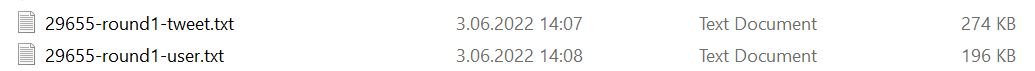

In [ ]:
display.Image("https://i.imgur.com/lcwRsOW.png")

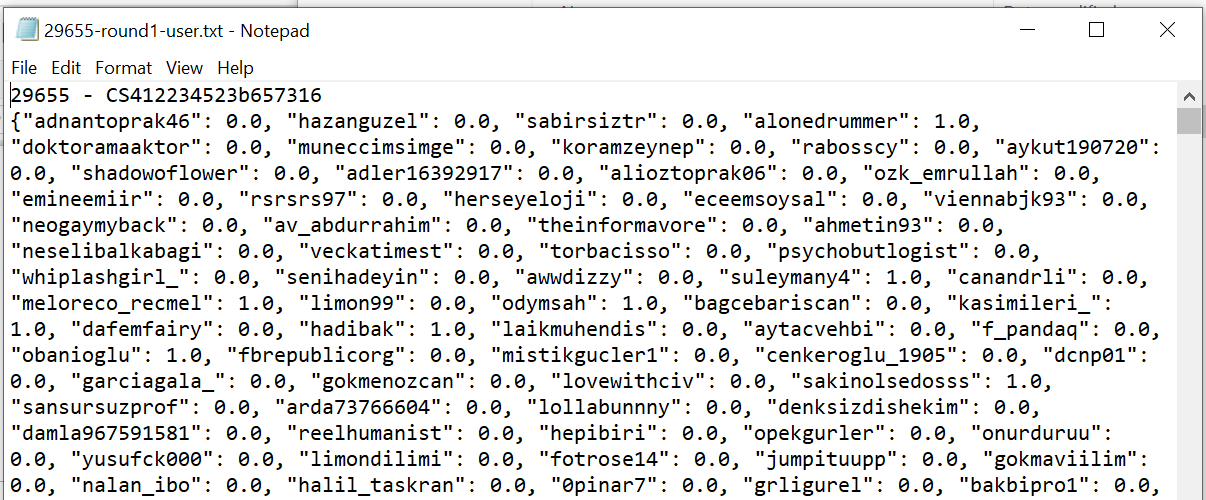

In [ ]:
display.Image("https://i.imgur.com/qfxqgMF.png")

You can check whether you can read your predictions correctly or not:

In [157]:
with open('{}/{}-round{}-tweet.txt'.format(DATA_PATH, STUDENT_ID, ROUND), 'r') as fl:
    file = fl.read()

student_info = file.split("\n")[0]
predictions = eval(file.split("\n")[1])